In [414]:
import os
import time
import numpy as np
import collections
import matplotlib.pyplot as plt

from tqdm import trange
from scipy import sparse, linalg
from constants import *
from scipy.special import k0
from ULDM_Simulator import *


plt.style.use('./myplot.mplstyle')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Slow mode in time domain

Slow mode residuals in the time domain can be schematically written as

$$
\delta t = \boldsymbol a^\dagger \cdot \boldsymbol H \cdot \boldsymbol a
$$

By diagonalizing the matrix $\boldsymbol H$ and analyzing its eigenvalues, we will see if the Gaussian approximation is reasonable one for the analysis of slow mode residuals. We first perform this analysis in the time domain.

In [ ]:
def f(w):
    '''
    Dark matter velocity distribution
    but with w = mv^2/2 as an argument

    Input
        w   (float)     frequency / m sigma^2
    '''
    return np.exp(-w)

def v(w):
    '''
    dark matter velocity / velocity dispersion

    Input
        w   (float)     frequency / m sigma^2
    '''

    return np.sqrt(2 * w)

def kernel(w,m,p):
    w1 = w[:, None]
    w2 = w[None, :]
    v1 = v(w)[:, None]
    v2 = v(w)[None, :]
    c1 = m[:, None]
    c2 = m[None, :]
    s1 = np.sqrt(1 - c1**2)
    s2 = np.sqrt(1 - c2**2)
    p1 = p[:,None]
    p2 = p[None,:]

    ik12n = 1j * (v1 * c1 - v2 * c2)
    
    k12sq = (v1**2 + v2**2 - 2 * v1 * v2 * (s1 * s2 * np.cos(p1) * np.cos(p2) 
                                          + s1 * s2 * np.sin(p1) * np.sin(p2)
                                          + c1 * c2))
    
    result = np.sqrt(f(w1) * f(w2)) * v1 * v2 * ik12n
    
    result = np.divide(result, (w1 - w2)**2 * k12sq, 
                       where= (w1 - w2)**2 * k12sq !=0,
                       out=np.zeros((len(w),len(w)), dtype='complex128'))
    
    np.fill_diagonal(result, 0)
    return result


In [ ]:
w = np.linspace(0.1, 5, 20)
m = np.linspace(-0.99,0.99, 10)
p = np.linspace(0, 2*np.pi, 10)

W, M, P = np.meshgrid(w, m, p, indexing='ij')

In [ ]:
w, m, p = W.flatten(), M.flatten(), P.flatten()

In [ ]:
ker = kernel(w,m,p)

In [ ]:
eigs = np.real(np.linalg.eig(ker)[0])
# eigs = eigs[np.abs(eigs)>1e-1]

In [ ]:
len(eigs[np.abs(eigs)>1e-1])/ len(eigs)

0.855

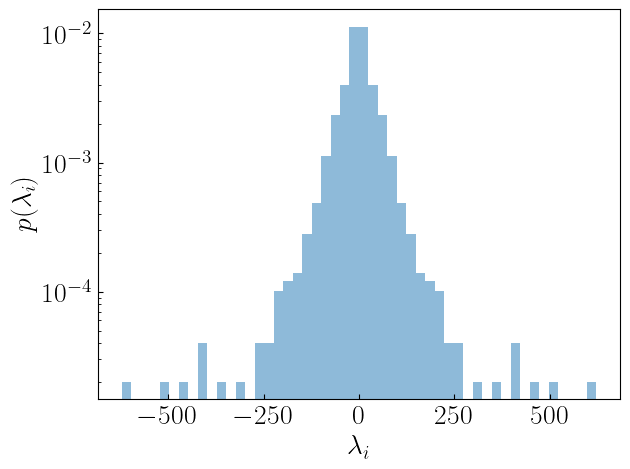

In [ ]:
plt.hist(eigs, 
         bins=50,
         alpha=0.5, 
         density=True);

plt.yscale('log')
plt.xlabel(r'$\lambda_i$')
plt.ylabel(r'$p(\lambda_i)$')

plt.tight_layout()
plt.savefig('./figs/eig_dist.pdf')

In [ ]:
count, bins = np.histogram(eigs, bins=50, density=True)

In [ ]:
tmp = []
for i in range(len(bins)):
    if i ==0:
        curr = eigs[(eigs > -np.inf) & (eigs < bins[i])]
    curr = eigs[(eigs > bins[i-1]) & (eigs < bins[i])]
    if len(curr) != 0:
        tmp.append(np.mean(curr) * len(curr)/len(eigs))
    else:
        tmp.append(0)

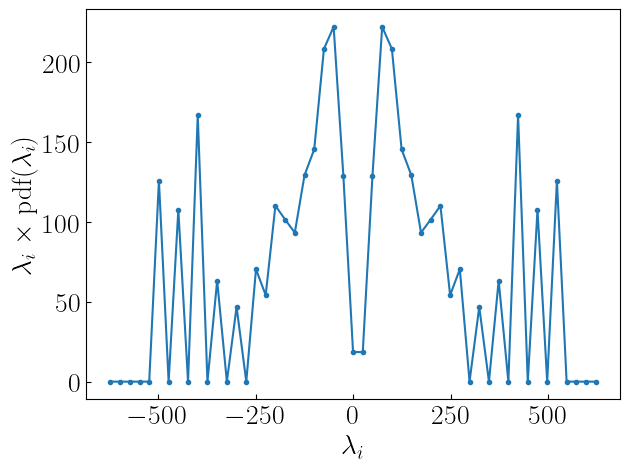

In [ ]:
plt.plot(bins,tmp, '.-')
plt.xlabel(r'$\textrm{$\lambda_i$}$')
plt.ylabel(r'$\textrm{$\lambda_i$ $\times$ pdf$(\lambda_i)$}$')

plt.tight_layout()
plt.savefig('./figs/eig_mean_dist.pdf')

In [ ]:
tmp = []
for i in range(len(bins)):
    if i ==0:
        curr = eigs[(eigs > -np.inf) & (eigs < bins[i])]
    curr = eigs[(eigs > bins[i-1]) & (eigs < bins[i])]
    if len(curr) != 0:
        tmp.append(np.mean(curr)**2 * len(curr)/len(eigs))
    else:
        tmp.append(0)

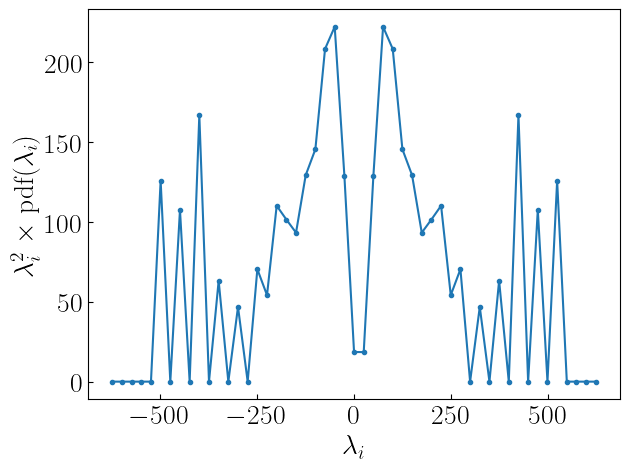

In [ ]:
plt.plot(bins,tmp, '.-')
plt.xlabel(r'$\textrm{$\lambda_i$}$')
plt.ylabel(r'$\textrm{$\lambda_i^2$ $\times$ pdf$(\lambda_i)$}$')

plt.tight_layout()
plt.savefig('./figs/eig_var_dist.pdf')

# Frequency Domain

In [655]:
class FreqDomain:
    def __init__(self, mass, T=20, sigma=160):
        '''
        Input
            mass    (scalar)    Mass [Hz]
            T       (scalar)    Total observational time span [yr]
            sigma   (scalar)    Velocity dispersion [km/sec]
        '''
        
        self.mass = mass                                # mass [Hz]
        self.sigma = sigma                              # vel dispersion [km/sec]
        self.T = T * yr                                 # total time baseline [sec]
        self.df = 1 / self.T                            # freq. resolution [Hz]
        self.tau = 1 / (mass * (sigma / c)**2)          # coherence time [sec]
        self.kin = mass * (sigma / c)**2                # typ. kinetic energy [Hz]
        
        self.H = collections.defaultdict()
        self.eigs = collections.defaultdict()

        self.set_vel_dist()
        self.set_grid()

    def set_vel_dist(self):
        '''
        Set up velocity distribution f_v(f)
        as a function of frequency
        '''
        self.fvel = lambda f: np.exp( - 2 * np.pi * f * self.tau ) / (2 * np.pi)**(3/2) / (self.sigma / c)**2

    def v(self, f):
        '''
        Velocity as a function of frequency
        Input
            f   (scalar)    frequency [Hz]
        '''
        return np.sqrt(4 * np.pi * f / self.mass)
    
    def set_grid(self, max_f=10, Nm=5, Nphi=5):
        '''
        Setting grid for the summation
        Input
            max_f   (scalar)    maximum frequency in m sigma^2 unit
            Nm      (scalar)    number of grid in \cos\mu
            Nphi    (scalar)    number of grid in \phi
        '''

        Nf = max(10, int(max_f * self.kin / self.df))
        
        f = np.arange(1, Nf)                # frequency array [df unit]
        m = np.linspace(-0.99, 0.99, Nm)    # \cos\mu array
        p = np.linspace(0, 2*np.pi, Nphi)   # \phi array

        self.F, self.M, self.P = np.meshgrid(f, m, p, indexing='ij')
        
        self.F = self.F.flatten()
        self.M = self.M.flatten()
        self.P = self.P.flatten()

    def compute_H(self, i:int):
        '''
        Compute H matrix and its eigenvalues
        Input
            i   (scalar)    which frequency do we compute H? f_i = i / T
        '''
        if i - 1 not in self.H:
            f1 = self.F[:, None] * self.df
            f2 = self.F[None, :] * self.df
            v1 = self.v(self.F * self.df)[:, None]
            v2 = self.v(self.F * self.df)[None, :]
            c1 = self.M[:, None]            # \cos\theta_1
            c2 = self.M[None, :]            # \cos\theta_2
            s1 = np.sqrt(1 - c1**2)         # \sin\theta_1
            s2 = np.sqrt(1 - c2**2)         # \sin\theta_2
            p1 = self.P[:, None]            # \phi_2
            p2 = self.P[None, :]            # \phi_2

            ik12n = 1j * (v1 * c1 - v2 * c2)        # assuming n = (0, 0, 1) WLOG
            k12sq = (v1**2 + v2**2 - 2 * v1 * v2 * (s1 * s2 * np.cos(p1) * np.cos(p2) 
                                                    + s1 * s2 * np.sin(p1) * np.sin(p2)
                                                    + c1 * c2))
            
            result = np.sqrt(self.fvel(f1) * self.fvel(f2)) * v1 * v2 * ik12n

            result = np.divide(result, 
                               (f1 - f2)**2 * k12sq,
                               where=((f1 - f2)**2 * k12sq != 0),
                               out=np.zeros((len(self.F), len(self.F)), dtype='complex128'))
            
            mask = (self.F[:, None] + i == self.F[None, :]).astype(int)
            result = result * mask
            
            self.H[i - 1] = result
            self.eigs[i - 1] = sparse.linalg.eigs(result, k=len(self.F)-5)[0]

In [659]:
test = FreqDomain(mass=1e-2)
test.compute_H(1)

In [660]:
test.eigs[0]

array([-1.38355270e+12-4.33266424e+12j, -4.38568094e+12+1.81563191e+11j,
        3.28589406e+12-2.62395253e+12j, -5.24839112e+11+4.03462079e+12j,
        3.64877004e+12+1.66086065e+12j, -2.53625235e+12+1.87918329e+12j,
        8.81942086e+11+3.04879022e+12j, -2.07189275e+12-2.10824496e+12j,
        1.43235648e+12-2.41747309e+12j,  2.76355035e+12+3.48443741e+11j,
        1.82385379e+12-1.81609072e+12j, -7.63366051e+11-2.20580591e+12j,
        2.13759656e+12+1.15263412e+12j, -2.12370396e+12-5.67604457e+11j,
       -1.95205621e+12+8.93644868e+11j, -4.13303619e+11+1.92651201e+12j,
        8.10854553e+11-1.43879149e+12j,  1.55665034e+12+2.33074777e+11j,
       -9.74912960e+11-1.22120090e+12j,  4.17762988e+11+1.48225716e+12j,
        9.17983998e+11+1.13368785e+12j, -3.30406405e+11+1.44122838e+12j,
       -7.50056734e+11+1.26930467e+12j, -9.37607903e+11+1.12043894e+12j,
       -1.41045781e+12-2.67215344e+11j,  1.25918973e+12-5.43288475e+11j,
       -1.35882951e+12+5.62405241e+10j, -2.02528325